In [452]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

# The case for Survival Analysis

In [453]:
def mean_absolute_error(y_true, y_pred):
    return np.abs(y_true-y_pred).mean()

In [454]:
# load the data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
z_train = np.load('z_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
z_test = np.load('z_test.npy')


In [455]:
print('Number of training samples:', X_train.shape[0])
print('Number of features per sample:', X_train.shape[1])
print('Number of test samples:', X_test.shape[0])
print('Observed survival time: max {}, min {}:'.format(y_train.max(), y_train.min()))

Number of training samples: 3521
Number of features per sample: 15
Number of test samples: 3522
Observed survival time: max 72, min 0:


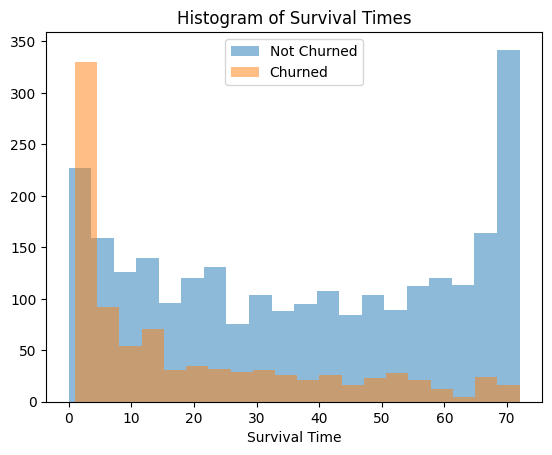

In [456]:
plt.hist(y_train[z_train==0], bins = 20, alpha=0.5, label='Not Churned')
plt.hist(y_train[z_train==1], bins = 20, alpha=0.5, label='Churned')
plt.legend()
plt.xlabel('Survival Time')
plt.title('Histogram of Survival Times');

In [457]:
# metrics for evaluation
def plot_results(y, prediction, z, save=False):
    plt.figure(figsize=(20,8))
    plt.subplot(131)
    plt.scatter(prediction, y, s=1)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.plot([0,70],[0,70], color='C1')
    plt.title(f'MAE {mean_absolute_error(y, prediction)}')

    plt.subplot(132)
    plt.scatter(prediction[z==1], y[z==1], s=1)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.plot([0,70],[0,70], color='C1')
    plt.title(f'MAE (Churned) {mean_absolute_error(y[z==1], prediction[z==1])}')

    plt.subplot(133)
    plt.scatter(prediction[z==0], y[z==0], s=1)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.plot([0,70],[0,70], color='C1')
    plt.title(f'MAE (Not Churned) {mean_absolute_error(y[z==0], prediction[z==0])}');
    if save:
        plt.tight_layout()
        timestamp = time.time()
        plt.savefig(f'comparison_{timestamp}.pdf')
        print(f'saved as comparison_{timestamp}.pdf')
    plt.show()
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.hist((y-prediction)[z==0]);
    plt.xlabel('y-f(x)')
    plt.title('Error if not Churned')
    plt.gca().axvline(x=0, color='grey', linewidth=1)
    plt.subplot(122)
    plt.hist((y-prediction)[z==1]);
    plt.xlabel('y-f(x)')
    plt.title('Error if Churned')
    plt.gca().axvline(x=0, color='grey', linewidth=1)
    if save:
        plt.tight_layout()
        timestamp = time.time()
        plt.savefig(f'error_{timestamp}.pdf')
        print(f'saved as error_{timestamp}.pdf')
    plt.show()
    
def compute_metrics(y, prediction, z):
    died_p = np.array(prediction[z==1])
    died_y = np.array(y[z==1])
    cindex = ((np.expand_dims(died_y,0)<=np.expand_dims(y,1))&(np.expand_dims(died_p,0)<=np.expand_dims(prediction,1))).sum()/(np.expand_dims(died_y,0)<=np.expand_dims(y,1)).sum()
    print(f'C-Index: {cindex}')
    underestimated = np.mean((prediction-y)[(prediction<y)&(z==1)])
    print(f'Average Underestimated Survival (Churned): {-underestimated}')
    underestimated = np.mean((prediction-y)[(prediction<y)&(z==0)])
    print(f'Average Underestimated Survival (Not Churned): {-underestimated}')

# Linear Survival SVM

In [458]:
# get data, which is comparable: for a given y_i, return X_j(i), y_j(i)
def get_comparable_data(y):
    comparable_y = np.max(observed_y[observed_y<y])
    idx = np.random.randint((observed_y==comparable_y).sum())
    return observed_X[observed_y==comparable_y][idx], observed_y[observed_y==comparable_y][idx]

In [459]:
# define y_comp, y_comp_bar: 
# y_comp = y_i for (i,j)in E
# y_comp_bar = y_j for (i,j)in E
# define X_comp, X_comp_bar: 
# X_comp = x_i for (i,j) in E
# X_comp_bar = x_j for (i,j) in E

observed_X = X_train[z_train==1]
observed_y = y_train[z_train==1]

y_comp = y_train[y_train>1]
X_comp = X_train[y_train>1]
data_comp_bar = list(map(get_comparable_data, y_comp))

X_comp_bar = np.vstack([dcb[0] for dcb in data_comp_bar])
y_comp_bar = np.hstack([dcb[1] for dcb in data_comp_bar])

In [460]:
X_comp.shape, X_comp_bar.shape

((3209, 15), (3209, 15))

In [461]:
observed_X.shape

(923, 15)

In [462]:
X_comp.shape

(3209, 15)

In [463]:
X_train.shape

(3521, 15)

In [464]:
# Construct matrix U, V, W, delta_y
U = (X_comp - X_comp_bar) @ (X_comp - X_comp_bar).T
V = X_train @ (X_train.T)
W = X_train @ (X_comp - X_comp_bar).T
delta_y = y_comp - y_comp_bar

In [465]:
V.shape

(3521, 3521)

In [466]:
Q = np.block([
    [U, W.T],
    [W, V]
])

In [467]:
Q.shape

(6730, 6730)

In [468]:
# Constant in the problem
n = X_train.shape[0]
E = y_comp.shape[0]
r_1 = 100 / E
r_2 = 10000 / n

In [469]:
### YOUR CODE HERE
# construct a diagonal Z matrix
Z = np.diag(z_train)

# quadratic program setup
alpha = cp.Variable(E)
beta = cp.Variable(n)
gamma = cp.Variable(n)
# initialize constraints
constraints = []
tolerance = 1e-20


constraints.append(cp.abs(cp.sum(beta-Z@gamma)) <= tolerance)

# add constraints for alpha
for i in range(E):
    constraints.append(alpha[i]>=0)
    constraints.append(alpha[i]<=r_1)
    
# add constraints for beta and gamma
for i in range(n):  
    constraints.append(beta[i]>=0)
    constraints.append(beta[i]<=r_2)
    constraints.append(gamma[i]>=0)
    constraints.append(gamma[i]<=r_2)



### FORMULATE AND SOLVE DM
x = cp.hstack([alpha, beta - Z@gamma])

dy_y = np.hstack([delta_y, y_train])
objective = -cp.quad_form(x, cp.atoms.affine.wraps.psd_wrap(Q)) + dy_y.T @ x

objective = cp.Maximize(objective)

In [470]:
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=1)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 23 02:35:07 AM: Your problem has 10251 variables, 20503 constraints, and 0 parameters.
(CVXPY) Nov 23 02:35:07 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 23 02:35:07 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 23 02:35:07 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 23 02:35:08 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 23 02:35:08 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr

53110.63074283145

In [471]:
print('optimal objective value:')
opt_objective = objective.value
print(opt_objective)

# omega = omega_1 + omega_2
omega_1 = alpha.value.dot(X_comp - X_comp_bar)
omega_2 = (beta.value - Z@gamma.value).dot(X_train)
omega = omega_1 + omega_2
print('omega in the regression is:')
omega

optimal objective value:
53110.63074283145
omega in the regression is:


array([-0.48930695,  0.3321059 ,  2.22820494,  0.07285509, -1.46173602,
        2.55627583, -4.48850795,  2.29100463,  2.49561895,  1.20263258,
        1.02119505,  0.46033403,  0.52272117, -0.02526166,  9.00246569])

In [472]:
gamma = gamma.value
beta = beta.value

In [477]:
idx = np.logical_or(beta > tolerance, np.logical_and(gamma>tolerance, z_train==1))
idx.sum()

2291

In [430]:
### YOUR CODE HERE
b = (y_train[idx] - X_train[idx] @ omega).mean()
prediction = b + X_train @ omega
### FIND THE PREDICTION ON THE TRAINING SET

In [431]:
# unique, counts = np.unique(b, return_counts=True)
# unique, counts

Training Performance
saved as comparison_1669165851.2898612.pdf


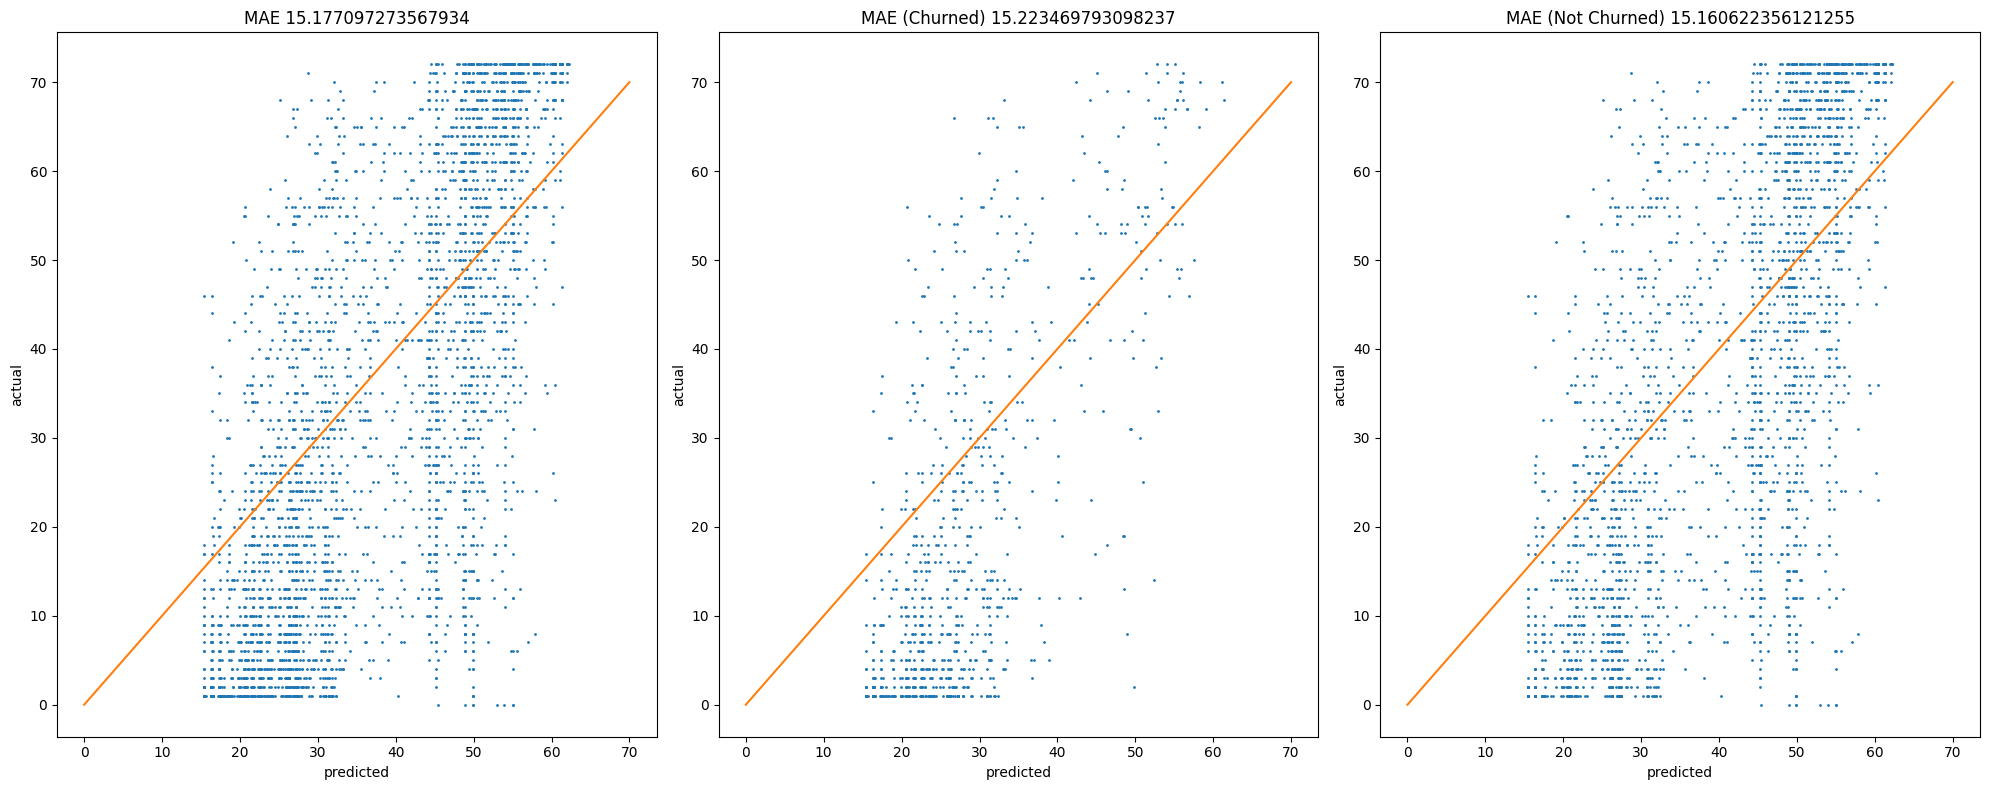

saved as error_1669165851.670916.pdf


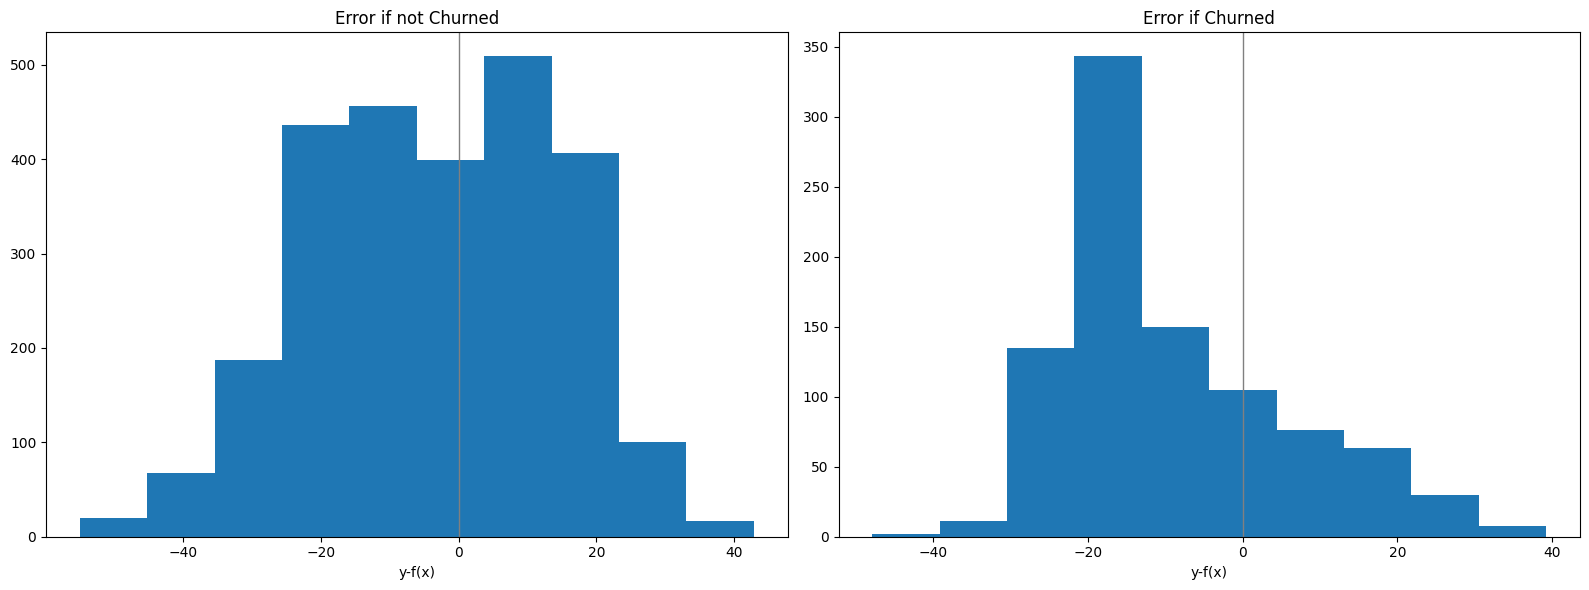

C-Index: 0.8476136470862309
Average Underestimated Survival (Churned): 12.68183316633734
Average Underestimated Survival (Not Churned): 13.054470192575993


In [432]:
print('Training Performance')
# plot the training performance
plot_results(y_train, prediction, z_train, save=True)
compute_metrics(y_train,prediction, z_train)

In [433]:
### YOUR CODE HERE
prediction = b + X_test @ omega
### FIND THE PREDICTION ON THE TEST SET

Testing Performance


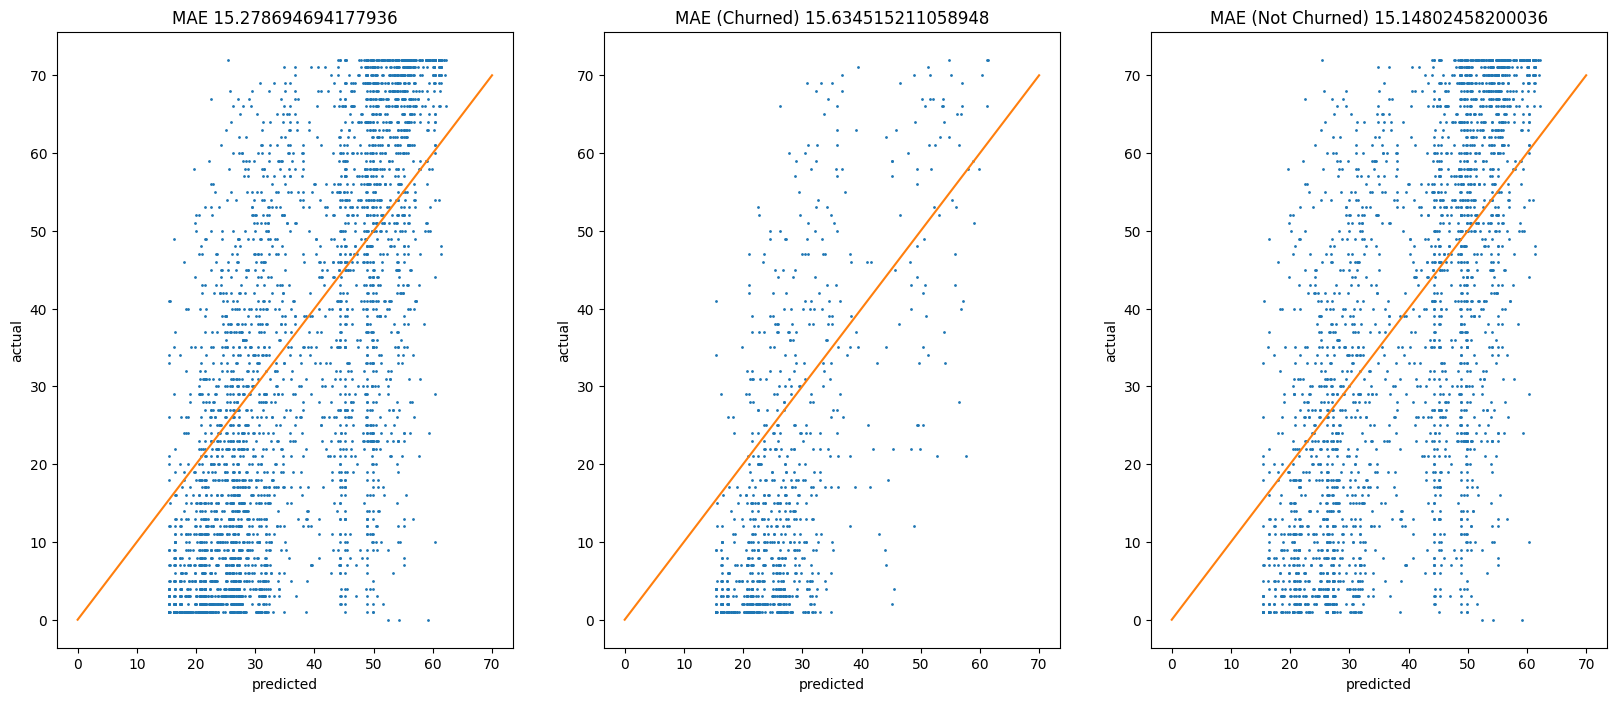

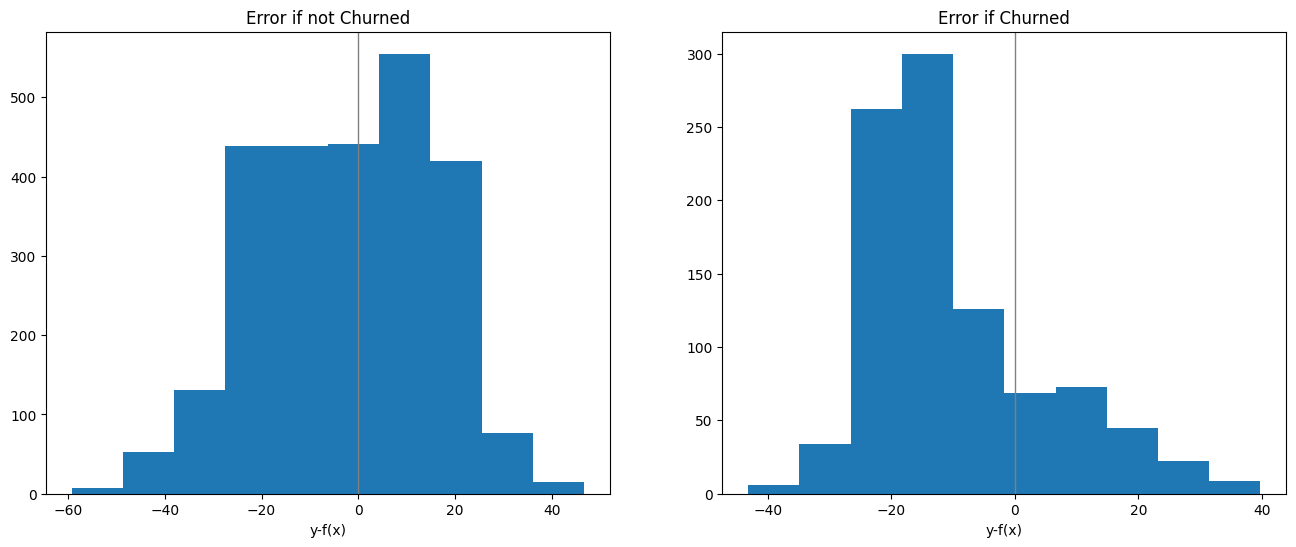

C-Index: 0.839440971197008
Average Underestimated Survival (Churned): 13.292536684267539
Average Underestimated Survival (Not Churned): 13.144489911817052


In [434]:
print('Testing Performance')
# plot the test performance
plot_results(y_test, prediction, z_test, save=False)
compute_metrics(y_test, prediction, z_test)

# Simple MAE Regression

In [435]:
### YOUR CODE HERE
# extract the dimensionality (number of features)
d = X_train.shape[1]

w = cp.Variable(15)
b = cp.Variable(1)

### FORMULATE AND SOLVE DM
objective = 0.5 * cp.quad_form(w, np.eye(d)) + r_2 * cp.sum( cp.abs( y_train - X_train @ w.T - b ) )
prob = cp.Problem(cp.Minimize(objective))
prob.solve(solver=cp.MOSEK, verbose=True)
### SOLVE THE MAE REGRESSION PROBLEM

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 23 02:10:53 AM: Your problem has 16 variables, 0 constraints, and 0 parameters.
(CVXPY) Nov 23 02:10:53 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 23 02:10:53 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 23 02:10:53 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 23 02:10:53 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 23 02:10:53 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

119805.10029304489

In [436]:
### YOUR CODE HERE
prediction_reg = X_train @ w.value.T + b.value
### FIND THE PREDICTION ON THE TRAINING SET

Training Performance
saved as comparison_1669165853.313226.pdf


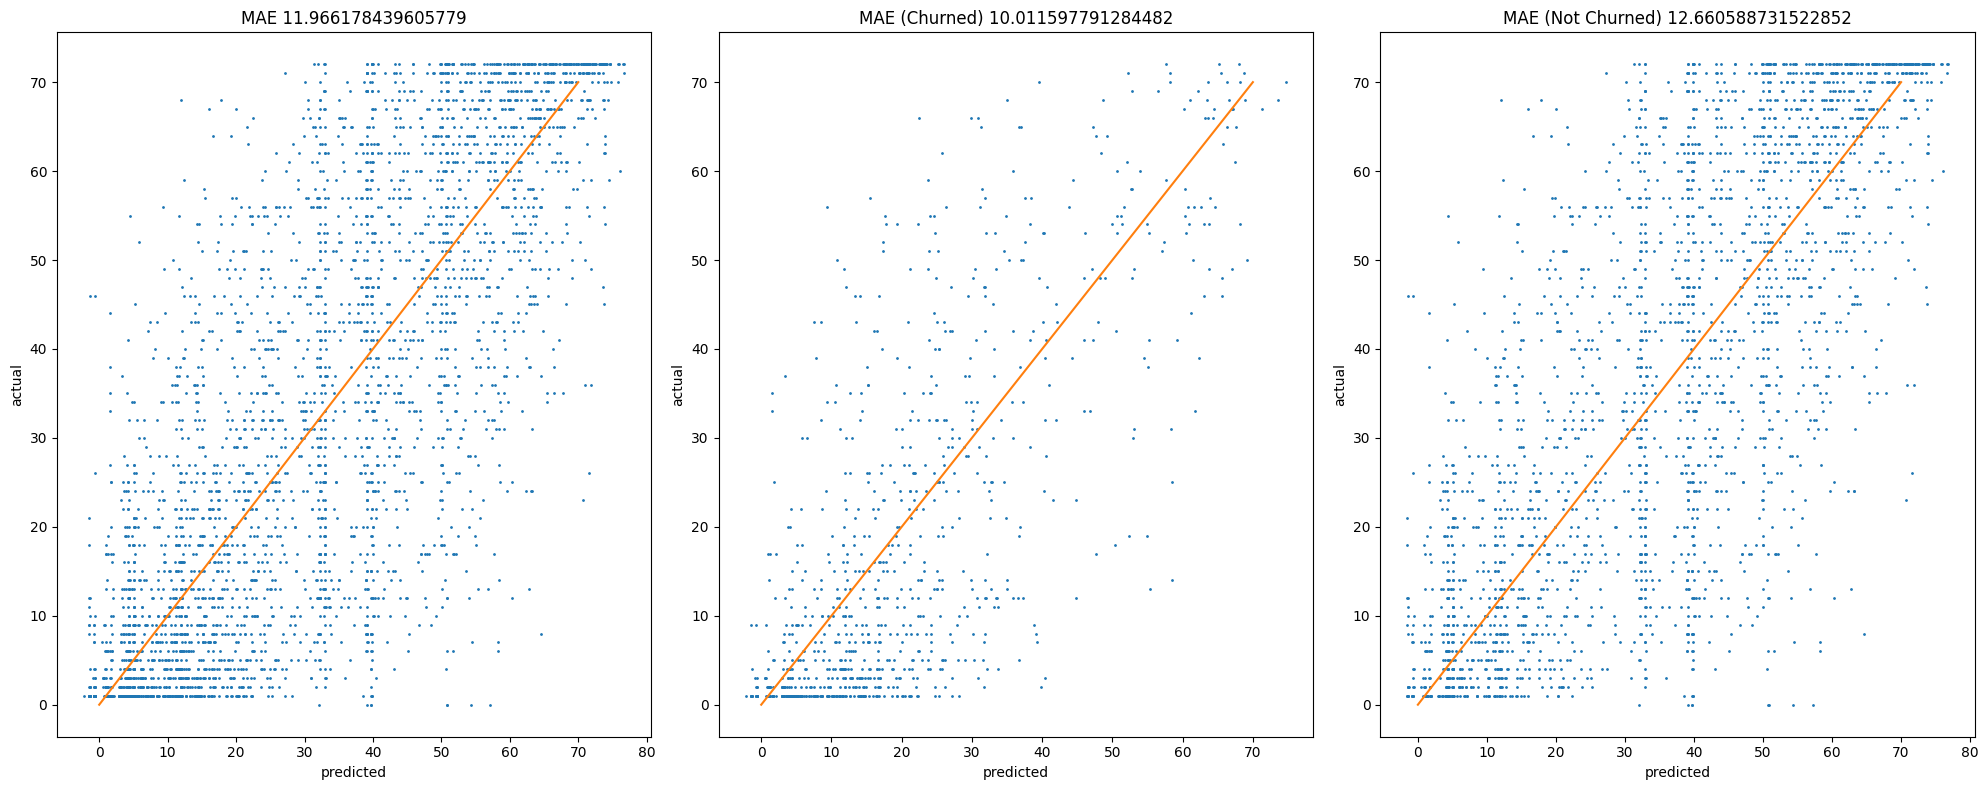

saved as error_1669165853.701168.pdf


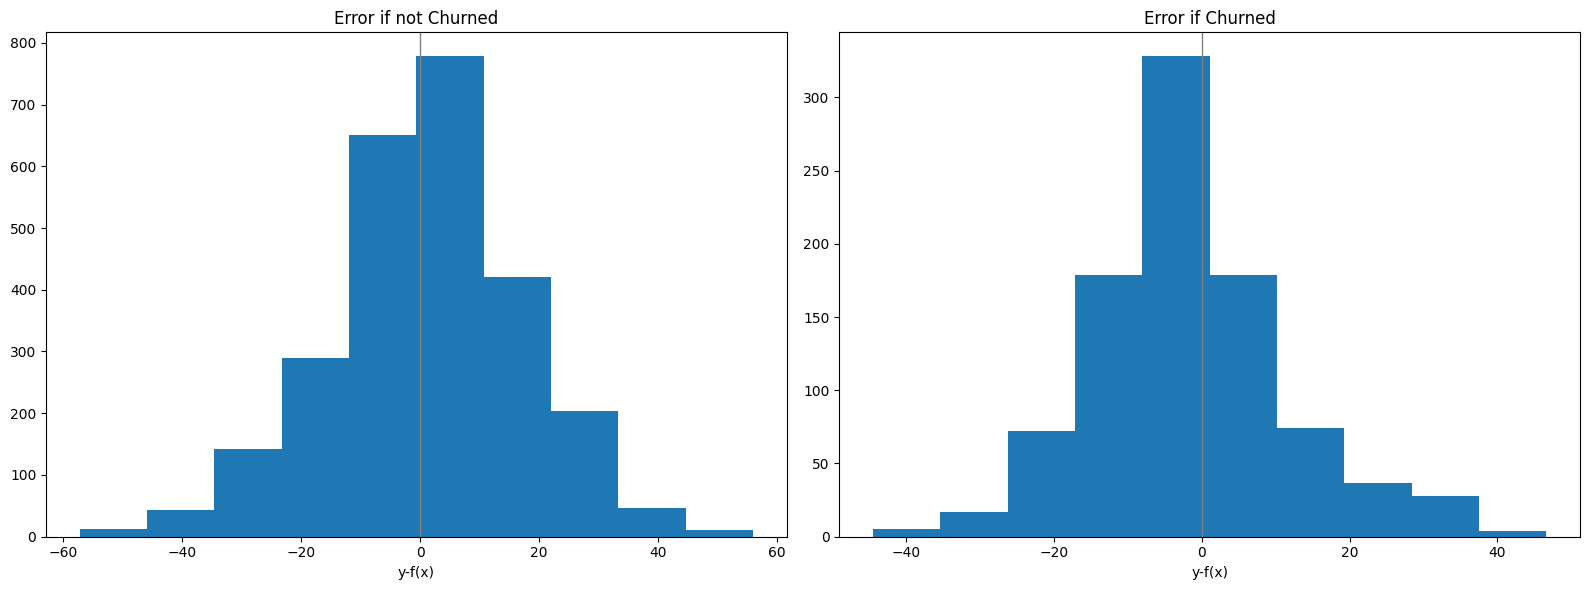

C-Index: 0.82914098699338
Average Underestimated Survival (Churned): 10.611452187969656
Average Underestimated Survival (Not Churned): 12.918426948857409


In [437]:
print('Training Performance')
plot_results(y_train, prediction_reg, z_train, save=True)
compute_metrics(y_train, prediction_reg, z_train)

In [438]:
### YOUR CODE HERE
prediction_reg = X_test @ w.value.T + b.value
### FIND THE PREDICTION ON THE TESTING SET

Testing Performance


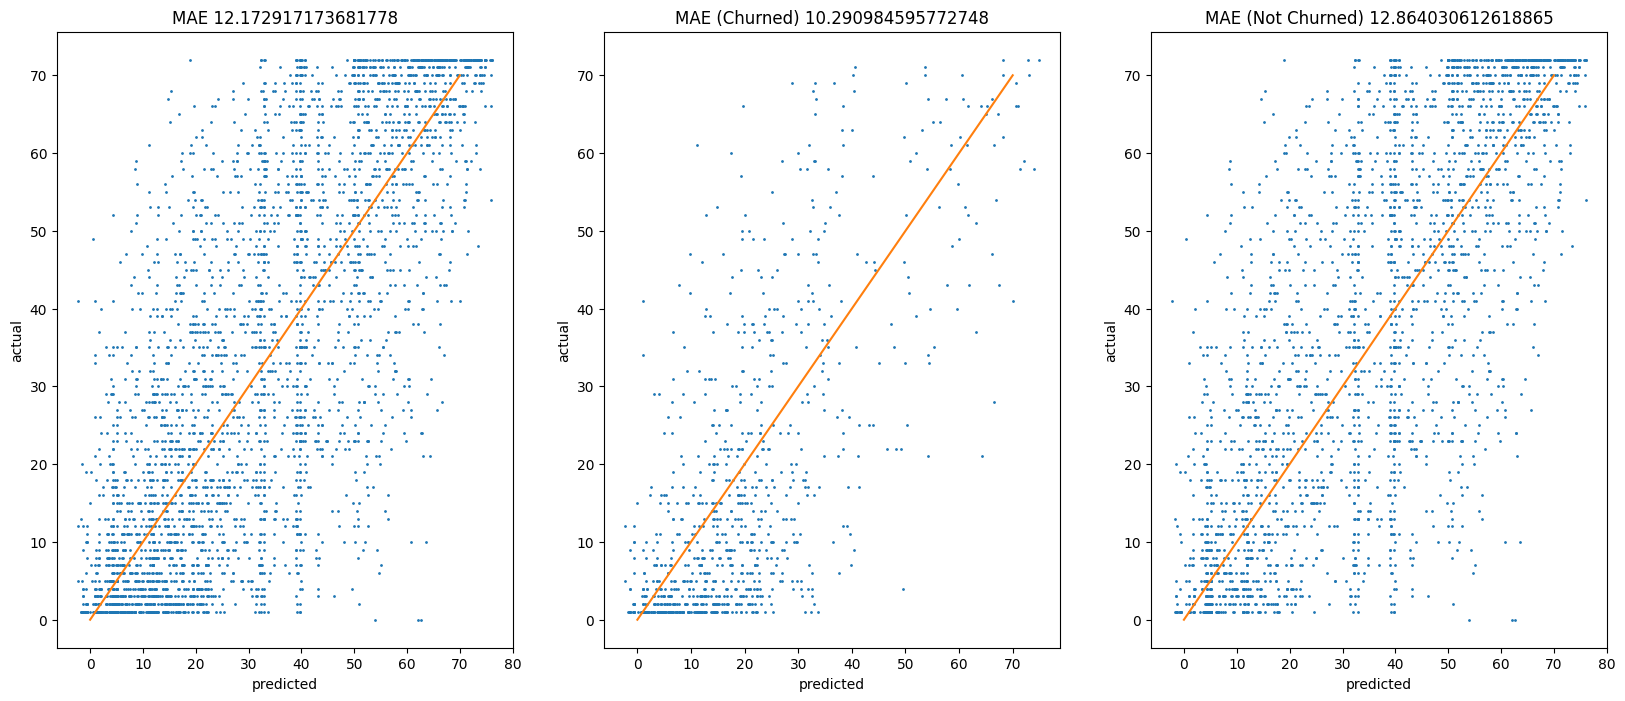

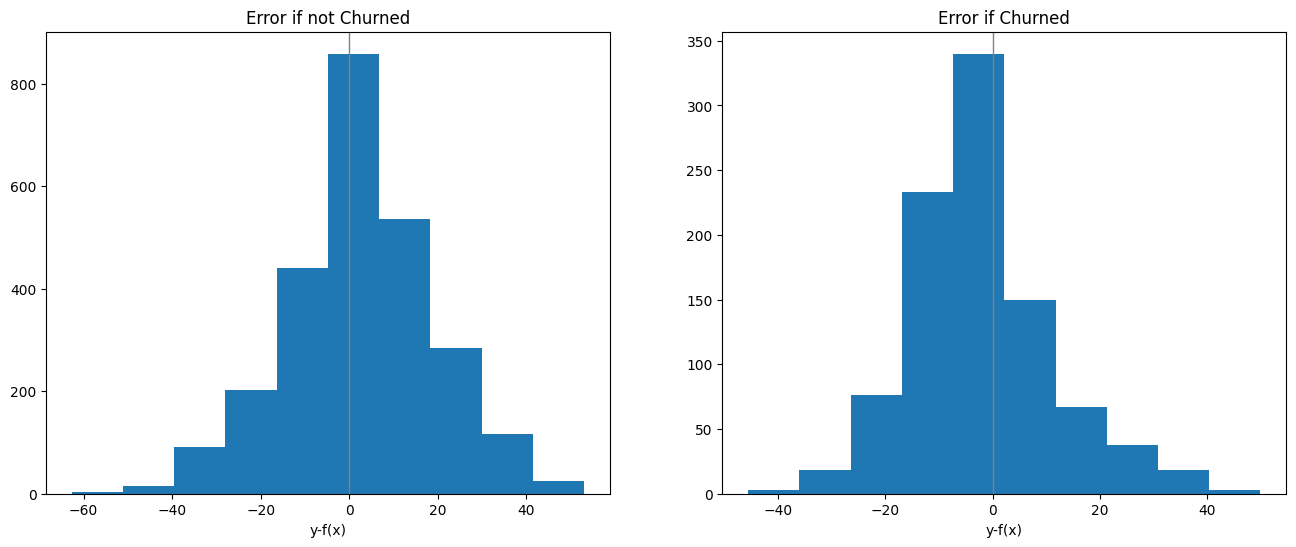

C-Index: 0.8237814036484075
Average Underestimated Survival (Churned): 11.149076776948796
Average Underestimated Survival (Not Churned): 13.682457719890273


In [439]:
print('Testing Performance')
plot_results(y_test, prediction_reg, z_test, save=False)
compute_metrics(y_test, prediction_reg, z_test)

# Kernelized Version

In [440]:
# sigma^2 to use for RBF Kernel
sigma2 = 1.5

In [441]:
# function to compute RBF Kernel Matrix between X1 and X2
def compute_rbf(X1, X2, sigma2=100):
    return np.exp(-((np.expand_dims(X2, 0)- np.expand_dims(X1, 1))**2).sum(axis=2)/(2*sigma2))


In [442]:
U

array([[ 3.87531408e+01,  5.14991047e-01, -1.21624763e+01, ...,
         1.21286420e+01, -4.00762515e+00,  1.07171089e+01],
       [ 5.14991047e-01,  2.87685119e+01, -3.81656820e+00, ...,
         7.40049591e-02, -6.16707992e-03, -1.32759746e+01],
       [-1.21624763e+01, -3.81656820e+00,  1.22848210e+01, ...,
         5.57167539e-03,  4.00474645e+00, -4.24071141e-01],
       ...,
       [ 1.21286420e+01,  7.40049591e-02,  5.57167539e-03, ...,
         1.21012425e+01, -1.31098245e-04,  7.26914857e+00],
       [-4.00762515e+00, -6.16707992e-03,  4.00474645e+00, ...,
        -1.31098245e-04,  8.01164653e+00,  4.01399031e+00],
       [ 1.07171089e+01, -1.32759746e+01, -4.24071141e-01, ...,
         7.26914857e+00,  4.01399031e+00,  3.55381541e+01]])

In [443]:
### YOUR CODE HERE
# Redefine matrix U V W
U = compute_rbf(X_comp - X_comp_bar, X_comp - X_comp_bar, sigma2)
V = compute_rbf(X_train, X_train, sigma2)
W = compute_rbf(X_train, X_comp - X_comp_bar, sigma2)

delta_y = y_comp - y_comp_bar

Q = np.block([
    [U, W.T],
    [W, V]
])



# quadratic program setup
alpha = cp.Variable(E)
beta = cp.Variable(n)
gamma = cp.Variable(n)
# initialize constraints
constraints = []
tolerance = 10e-12

# Constant in the problem
r_1 = 100 / E
r_2 = 10000 / n
Z = np.diag(z_train)

# initialize constraints
constraints = []

constraints.append(cp.abs(cp.sum(beta-np.matmul(Z,gamma))) <= tolerance)

# add constraints for alpha
for i in range(E):
    constraints.append(alpha[i]>=0)
    constraints.append(alpha[i]<=r_1)
    
# add constraints for beta and gamma
for i in range(n):  
    constraints.append(beta[i]>=0)
    constraints.append(beta[i]<=r_2)
    constraints.append(gamma[i]>=0)
    constraints.append(gamma[i]<=r_2)

### FORMULATE AND SOLVE DM
x = cp.hstack([alpha, beta - Z@gamma])

dy_y = np.hstack([delta_y, y_train])
objective = -cp.quad_form(x, cp.atoms.affine.wraps.psd_wrap(Q)) + dy_y.T @ (x)

objective = cp.Maximize(objective)

### FORMULATE AND SOLVE DM-KERNELIZED

prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=1)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 23 02:10:56 AM: Your problem has 10251 variables, 20503 constraints, and 0 parameters.
(CVXPY) Nov 23 02:10:57 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 23 02:10:57 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 23 02:10:57 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 23 02:10:57 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 23 02:10:57 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr

67871.46404238537

In [444]:
alpha = alpha.value
beta = beta.value
gamma = gamma.value

In [445]:
beta.shape

(3521,)

In [446]:
# Deduce b
idx = np.logical_or(beta>0, np.logical_and(gamma>0, z_train==1))

In [447]:
### YOUR CODE HERE

raw = alpha @ compute_rbf(X_comp - X_comp_bar, X_train[idx], sigma2) + (beta - Z @ gamma) @ compute_rbf(X_train, X_train[idx], sigma2)
b = np.mean(y_train[idx] - raw)
prediction_rbf = alpha @ compute_rbf(X_comp - X_comp_bar, X_train, sigma2) + (beta - Z @ gamma) @ compute_rbf(X_train, X_train, sigma2) + b
### FIND THE PREDICTION ON THE TRAINING SET

In [448]:
prediction_rbf

array([40.94186574, 50.35278978, 31.89770028, ..., 35.630367  ,
       34.19350723, 51.1901496 ])

Training Performance


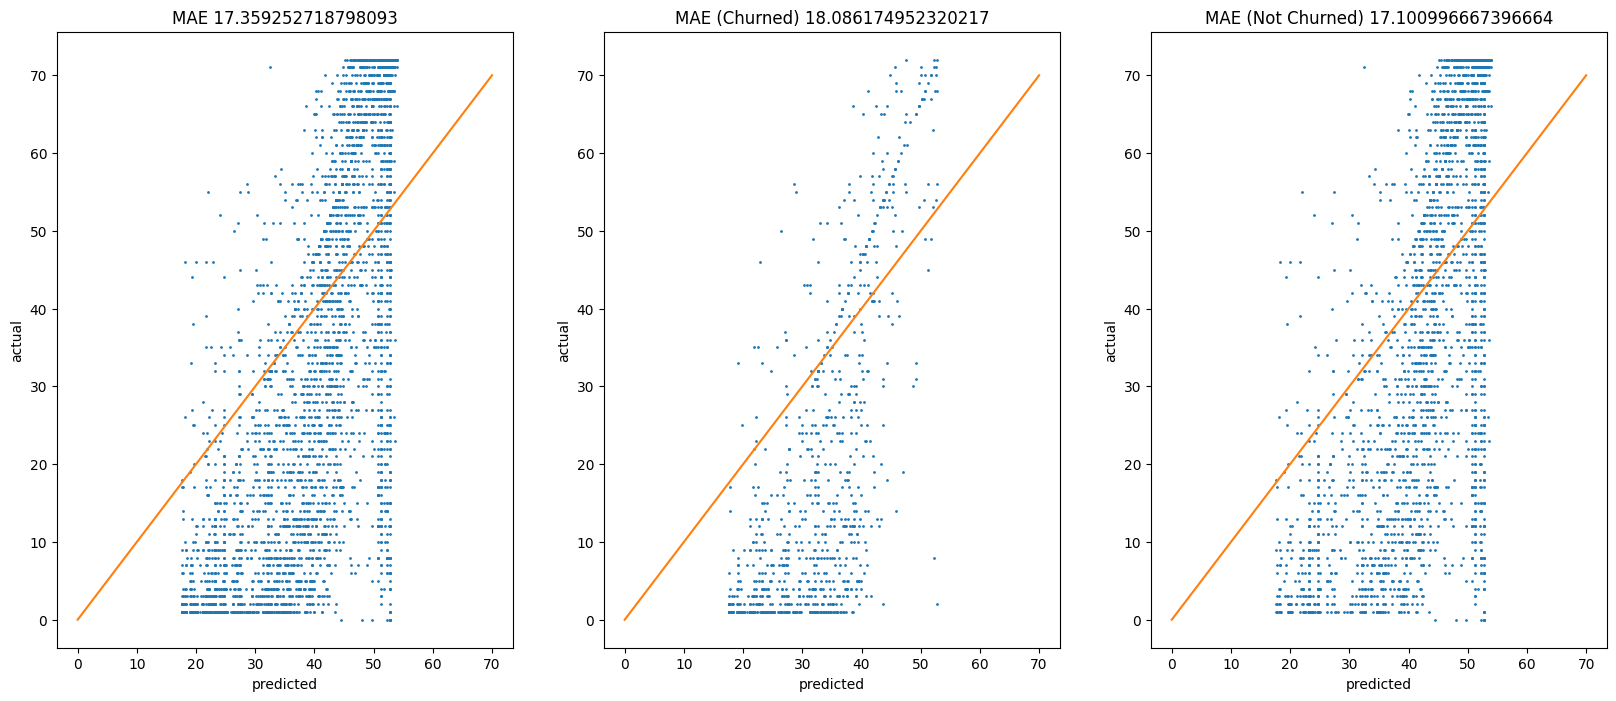

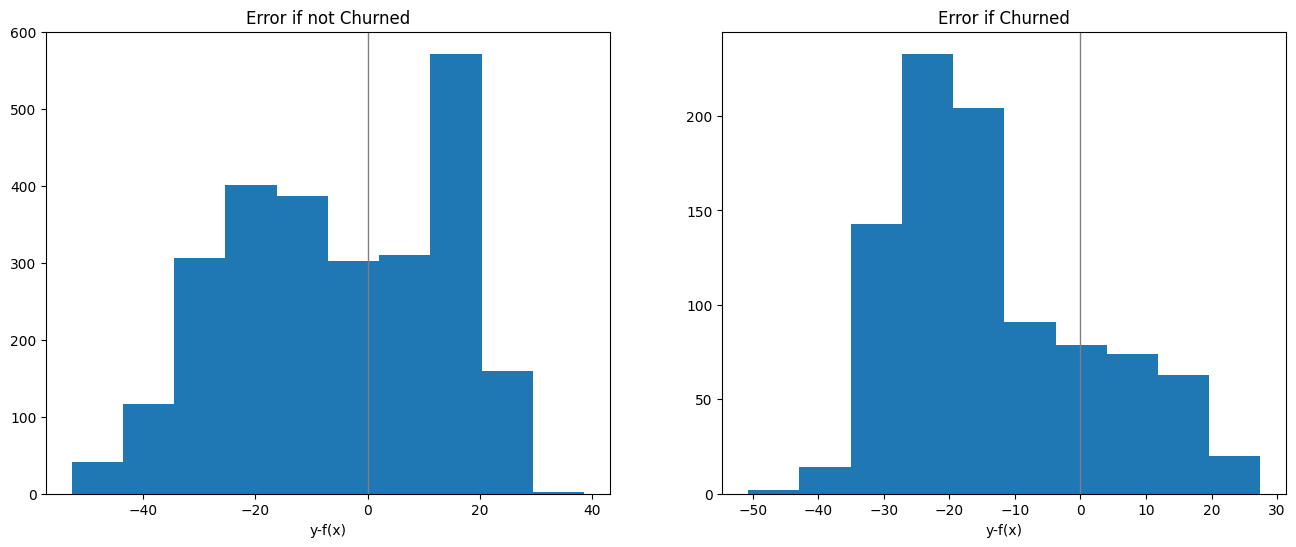

C-Index: 0.8702268088339732
Average Underestimated Survival (Churned): 10.774980061185245
Average Underestimated Survival (Not Churned): 13.861690569023997


In [449]:
print('Training Performance')
# training results
plot_results(y_train, prediction_rbf, z_train, save=False)
compute_metrics(y_train, prediction_rbf, z_train)

In [450]:
### YOUR CODE HERE
prediction_rbf = alpha @ compute_rbf(X_comp - X_comp_bar, X_test, sigma2) + (beta - Z @ gamma) @ compute_rbf(X_train, X_test, sigma2) + b
### FIND THE PREDICTION ON THE TEST SET

Testing Performance


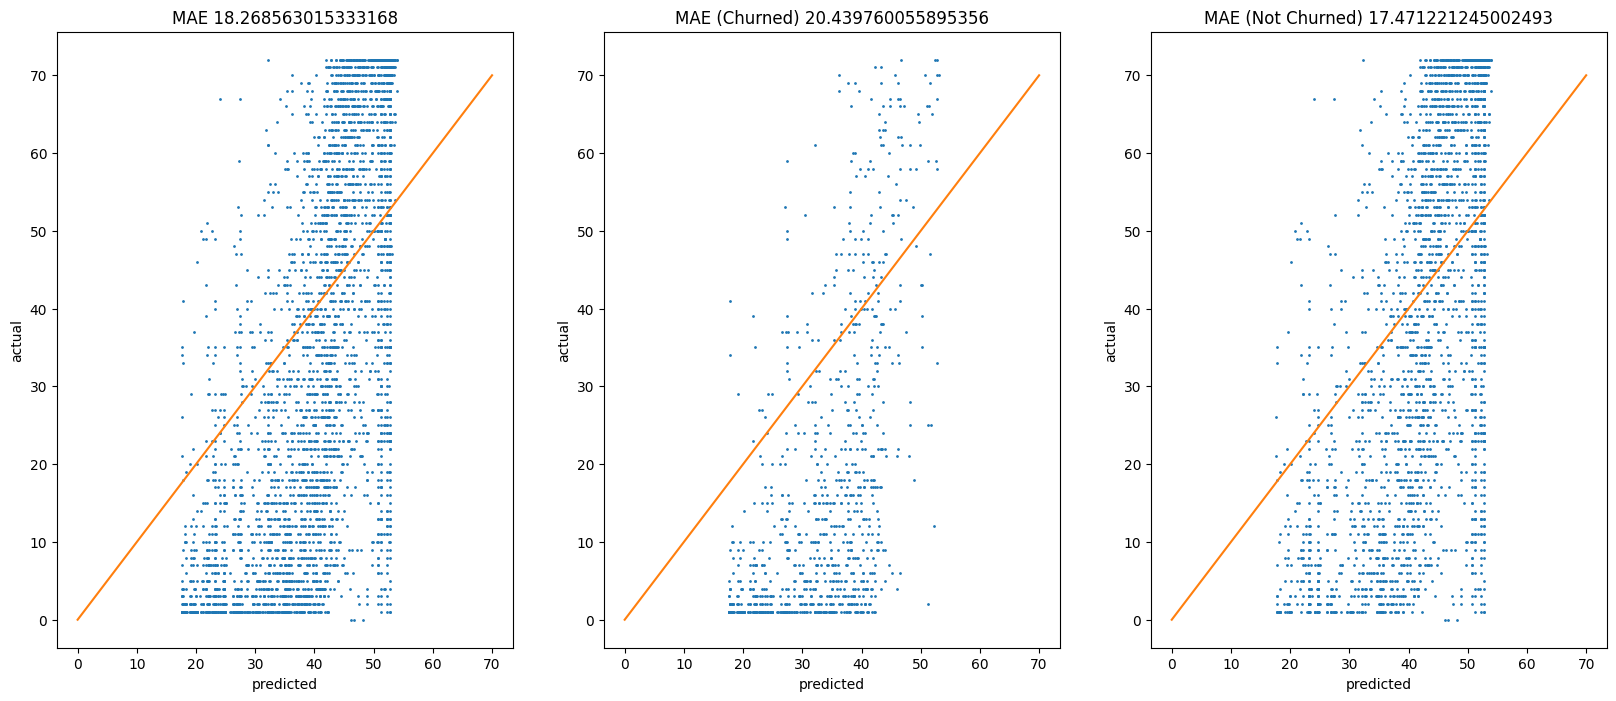

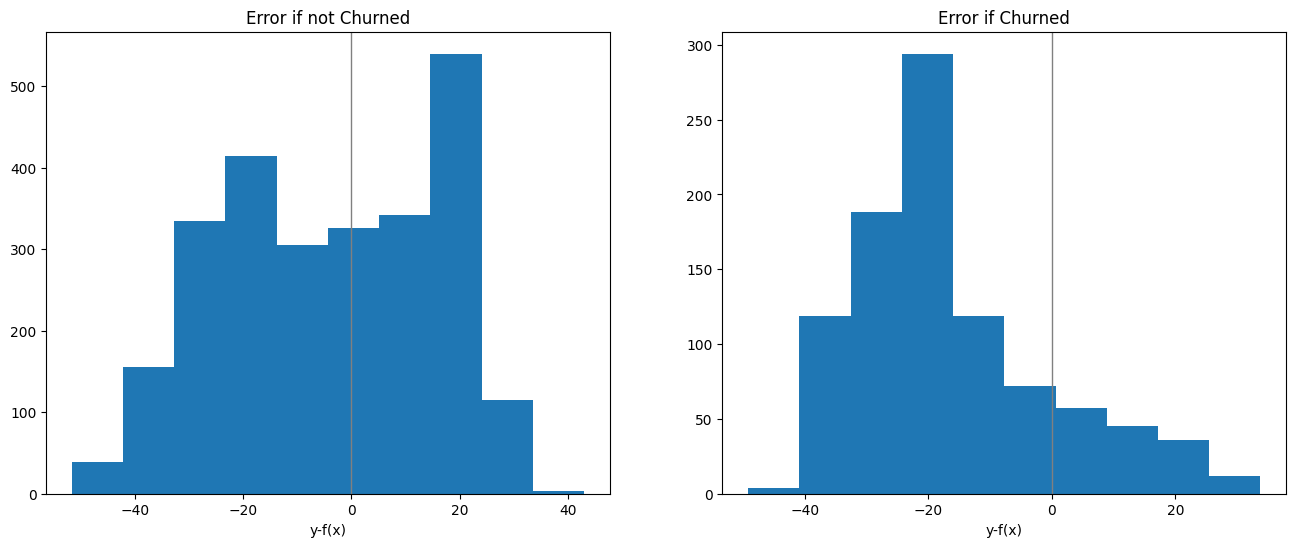

C-Index: 0.8284084538985241
Average Underestimated Survival (Churned): 12.30240573046584
Average Underestimated Survival (Not Churned): 14.883722406356359


In [451]:
print('Testing Performance')
# testing results
plot_results(y_test, prediction_rbf, z_test, save=False)
compute_metrics(y_test, prediction_rbf, z_test)